Why Use Embeddings Instead of One-Hot Encoding?
Dimensionality Reduction

One-hot encoding creates a sparse vector with a size equal to the vocabulary (V).

If V = 65 (like in your character-level model), then each one-hot vector is of size 65, mostly filled with zeros.

Instead, an embedding layer maps each character to a smaller, dense vector (e.g., size n_embd = 32), reducing computational cost.

Capturing Contextual Meaning 

In one-hot encoding, there's no notion of similarity between characters/words.

In an embedding space, similar characters/words (e.g., "c" and "k" or "dog" and "puppy") get closer vector representations.

Scalability for N-grams 🚀

Previously, your model only considered one previous character (ix in xenc).

Extending to n-grams means storing a V^n probability table, which blows up in size.

Instead, embeddings allow us to compress the information into a fixed-size vector, avoiding this explosion.

- Every index plucks out a row from indexing table(16999,30).So it reduces to 30 dimension
- Suppose we have 3 index so it makes 90 neurons in total.
- Now we have hidden layer(size hyperparamater)
- Supoose we have 100 neurons in hidden layer,all of them will be fully connected to 90 char or neurons.
- The output layer has 17000 neurons.
- Softmax is applied and normalized.
- we have label and that index is used to pluck out probability and minimize loss.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype # each input to neural network is 3

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

### Implementing embedding look up table

In [24]:
# We try to embbded the 27 characters to a two dimensional space

In [8]:
C = torch.randn((27,2))
C.shape

torch.Size([27, 2])

In [9]:
C[5]

tensor([0.1121, 0.4590])

In [10]:
F.one_hot(torch.tensor(5),num_classes=27).float() @ C # it just masks the other field except one i.e it plucks row index 4

tensor([0.1121, 0.4590])

In [11]:
C[torch.tensor([5,6,7,7,7,7])] # indexing with one-dimensional tensor of integer

tensor([[ 0.1121,  0.4590],
        [-1.6131,  1.6213],
        [-0.3135,  0.9303],
        [-0.3135,  0.9303],
        [-0.3135,  0.9303],
        [-0.3135,  0.9303]])

In [12]:
C[X]# for every X, we have retrived the embedding. #32,3,2

tensor([[[ 0.4794, -0.3061],
         [ 0.4794, -0.3061],
         [ 0.4794, -0.3061]],

        [[ 0.4794, -0.3061],
         [ 0.4794, -0.3061],
         [ 0.1121,  0.4590]],

        [[ 0.4794, -0.3061],
         [ 0.1121,  0.4590],
         [ 0.5714,  0.1948]],

        [[ 0.1121,  0.4590],
         [ 0.5714,  0.1948],
         [ 0.5714,  0.1948]],

        [[ 0.5714,  0.1948],
         [ 0.5714,  0.1948],
         [-1.5317,  1.1566]],

        [[ 0.4794, -0.3061],
         [ 0.4794, -0.3061],
         [ 0.4794, -0.3061]],

        [[ 0.4794, -0.3061],
         [ 0.4794, -0.3061],
         [ 0.8091, -1.7270]],

        [[ 0.4794, -0.3061],
         [ 0.8091, -1.7270],
         [ 1.7060,  0.4160]],

        [[ 0.8091, -1.7270],
         [ 1.7060,  0.4160],
         [-0.7608,  0.4915]],

        [[ 1.7060,  0.4160],
         [-0.7608,  0.4915],
         [-0.9848, -1.0710]],

        [[-0.7608,  0.4915],
         [-0.9848, -1.0710],
         [-0.7608,  0.4915]],

        [[-0.9848, -1

For every 3 elements in the columns of the X,it has trasnsformed each element into 2 dimensional integer.

In [13]:
X[1,2]

tensor(5)

In [14]:
C[X][1,2] #== C[5] C[X][1,2] means from C[x] select 1 and then go inside 1 to select 2

tensor([0.1121, 0.4590])

In [15]:
C[5]

tensor([0.1121, 0.4590])

In [16]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

### Implementing the hidden layer

In [17]:
w1 = torch.randn((6,100)) # no of inputs = 3*2 as we have 2-d embedding and we have 3 of them(100 nuerons initliaze)
b1 = torch.randn(100)

In [18]:
w1.shape

torch.Size([6, 100])

In [53]:
#emb @ w1 + b1 # (32,3,2) @ (6,100)

- emb[:,0,:] : It selects along all the samples, 0 selects only the first embeddings and : selects across all the first embedding

In [36]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape # not generalized

torch.Size([32, 6])

In [37]:
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([32, 6])

In [38]:
a = torch.arange(18)
a.shape

torch.Size([18])

In [39]:
a.view(9,2) # as long as total number of elements multiplies to be same,it works

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [40]:
a.storage # tensor is always represented as 1d in memory

<bound method Tensor.storage of tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])>

In [14]:
emb.shape

torch.Size([32, 3, 2])

In [42]:
emb.view(32,6)

tensor([[ 0.9720, -2.4192,  0.9720, -2.4192,  0.9720, -2.4192],
        [ 0.9720, -2.4192,  0.9720, -2.4192, -0.4730,  0.9017],
        [ 0.9720, -2.4192, -0.4730,  0.9017,  1.5411, -1.0274],
        [-0.4730,  0.9017,  1.5411, -1.0274,  1.5411, -1.0274],
        [ 1.5411, -1.0274,  1.5411, -1.0274,  0.1552,  0.1962],
        [ 0.9720, -2.4192,  0.9720, -2.4192,  0.9720, -2.4192],
        [ 0.9720, -2.4192,  0.9720, -2.4192, -1.7019,  0.1018],
        [ 0.9720, -2.4192, -1.7019,  0.1018,  0.7051, -1.1771],
        [-1.7019,  0.1018,  0.7051, -1.1771,  1.4660,  0.9443],
        [ 0.7051, -1.1771,  1.4660,  0.9443, -0.8060,  2.0918],
        [ 1.4660,  0.9443, -0.8060,  2.0918,  1.4660,  0.9443],
        [-0.8060,  2.0918,  1.4660,  0.9443,  0.1552,  0.1962],
        [ 0.9720, -2.4192,  0.9720, -2.4192,  0.9720, -2.4192],
        [ 0.9720, -2.4192,  0.9720, -2.4192,  0.1552,  0.1962],
        [ 0.9720, -2.4192,  0.1552,  0.1962, -0.8060,  2.0918],
        [ 0.1552,  0.1962, -0.8060,  2.0

In [19]:
h = torch.tanh(emb.view(-1,6) @ w1 + b1)

In [20]:
h.shape

torch.Size([32, 100])

In [21]:
h

tensor([[-0.9862, -0.6933, -0.9714,  ...,  0.9214, -0.9986,  0.6488],
        [-0.9672, -0.6539, -0.9838,  ...,  0.5335, -0.9735,  0.9438],
        [-0.9136, -0.6529, -0.6361,  ...,  0.8377, -0.9981, -0.2533],
        ...,
        [-0.9936, -0.7986,  0.7351,  ...,  0.7802, -0.9986,  0.9871],
        [ 0.5678, -0.5599, -0.9843,  ..., -0.9272, -0.9348,  0.1073],
        [ 0.9487, -0.9539,  0.1167,  ..., -0.9499, -0.9553,  0.9954]])

### Implementing the output layer

In [22]:
w2 = torch.randn((100,27))
b2 = torch.randn(27)

### Implementing negative log likelihood

In [23]:
logits = h @ w2
logits.shape

torch.Size([32, 27])

In [24]:
counts = logits.exp()
counts

tensor([[9.1099e+01, 9.2621e+01, 5.7681e+02, 3.8498e-02, 1.4461e-02, 4.8323e+01,
         1.6925e-01, 2.5649e+04, 1.5505e+00, 2.3333e-01, 1.4197e+02, 3.0724e-01,
         2.4093e+02, 9.1286e+01, 1.8335e+00, 3.2034e-08, 3.2318e+00, 7.6553e+05,
         2.4708e-03, 1.8331e+02, 4.6030e-01, 2.4202e-01, 1.4278e-03, 7.2995e-04,
         1.8891e+00, 1.5313e+01, 1.8516e+01],
        [1.2493e-01, 2.9464e+02, 1.3383e+00, 1.0004e+01, 9.6498e-05, 2.8401e+01,
         1.4287e+01, 1.0869e+03, 1.9006e+01, 2.3558e+02, 6.7013e-02, 5.7793e-02,
         1.0924e+04, 5.9791e+00, 1.8573e+00, 1.9024e-08, 8.4705e+02, 2.0524e+05,
         5.3165e-04, 7.1336e-01, 1.3571e-02, 1.2659e+01, 2.3057e-02, 2.2430e-03,
         1.6878e+00, 1.6543e+04, 9.8425e-02],
        [1.0034e+00, 1.2936e-01, 4.9004e+00, 1.6094e+02, 3.2810e-02, 1.4387e+00,
         2.8581e+00, 1.0776e+04, 2.8289e+00, 1.2053e+02, 3.0043e-03, 2.3919e-02,
         3.2427e+01, 3.7090e-01, 1.9494e-03, 1.1844e-03, 1.2585e+00, 3.9359e+03,
         7.9348e-

In [25]:
prob = counts/counts.sum(1,keepdim=True)

In [26]:
prob.shape

torch.Size([32, 27])

In [27]:
prob[0]

tensor([1.1492e-04, 1.1684e-04, 7.2766e-04, 4.8566e-08, 1.8243e-08, 6.0960e-05,
        2.1352e-07, 3.2357e-02, 1.9560e-06, 2.9435e-07, 1.7910e-04, 3.8760e-07,
        3.0393e-04, 1.1516e-04, 2.3129e-06, 4.0412e-14, 4.0770e-06, 9.6574e-01,
        3.1169e-09, 2.3125e-04, 5.8068e-07, 3.0532e-07, 1.8011e-09, 9.2085e-10,
        2.3831e-06, 1.9318e-05, 2.3358e-05])

In [28]:
torch.arange(32),Y

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [29]:
prob[torch.arange(32),Y]

tensor([6.0960e-05, 2.5414e-05, 4.1905e-09, 5.8677e-06, 1.0936e-12, 4.0412e-14,
        7.9277e-08, 2.4293e-10, 1.9274e-09, 3.1924e-04, 1.2514e-11, 3.6716e-05,
        1.1684e-04, 8.5483e-06, 2.2077e-18, 3.6116e-02, 2.9435e-07, 9.8819e-10,
        7.1610e-13, 1.5036e-11, 6.0123e-06, 3.2125e-15, 1.2290e-14, 9.9343e-01,
        7.0110e-16, 2.3125e-04, 8.5465e-12, 3.9362e-13, 7.0006e-02, 6.0206e-11,
        1.7523e-10, 8.1105e-11])

In [30]:
loss = - prob[torch.arange(32),Y].log().mean()
loss

tensor(19.1225)

prob[torch.arange(32), Y]: This indexing operation does the following:

For the first row (sample 0), it selects the element from the 6th column (index 5) because Y[0] = 5. This is the predicted probability for the correct character (index 5) for the first sample.
For the second row (sample 1), it selects the element from the 13th column (index 12) because Y[1] = 12. This is the predicted probability for the correct character (index 12) for the second sample.
This continues for all 32 samples, selecting the predicted probability corresponding to the correct character for each sample.

In [54]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [55]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

### SUMMARY

In [31]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [32]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [33]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [34]:
for p in parameters:
    p.requires_grad = True

In [50]:
for _ in range(10):
    #forward pass
    emb = C[X] # 32,3,2
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y)
    print(loss.item())
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update 
    for p in parameters:
        p.data -= 0.1 * p.grad
    

2.574934720993042
2.5746254920959473
2.574327230453491
2.574038505554199
2.573758602142334
2.5734872817993164
2.573223114013672
2.5729668140411377
2.572716236114502
2.5724728107452393


In [48]:
logits.max(1)

torch.return_types.max(
values=tensor([2.5649, 3.0488, 3.5840,  ..., 2.1961, 2.1656, 2.6220],
       grad_fn=<MaxBackward0>),
indices=tensor([13,  1,  1,  ...,  0,  0,  0]))

In [37]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

### Training the full dataset

In [38]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [39]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [63]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [64]:
for p in parameters:
    p.requires_grad = True

In [1]:
import matplotlib.pyplot as plt

lre = torch.linspace(-3, 0, 100)
lrs_log = 10**lre
lrs_linear = torch.linspace(0.001, 1, 100)

plt.plot(lrs_log, label="Log Scale", marker="o")
plt.plot(lrs_linear, label="Linear Scale", marker="x")
plt.xscale("log")  # Log scale for better visualization
plt.legend()
plt.show()


NameError: name 'torch' is not defined

In [69]:
lre = torch.linspace(-3, 0, 1000) # 1000 numbers between -3 and 0
lrs = 10**lre

In [74]:
lri = []
lossi =  []
for i in range(10000):
    #mini_batch construct
    ix = torch.randint(0,X.shape[0],(32,))
    #forward pass
    emb = C[X[ix]] # 32,3,2
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y[ix])
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update 
    lr = 0.1
    for p in parameters:
        p.data -= 0.1 * p.grad

    #track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
print(loss.item())

2.3906760215759277


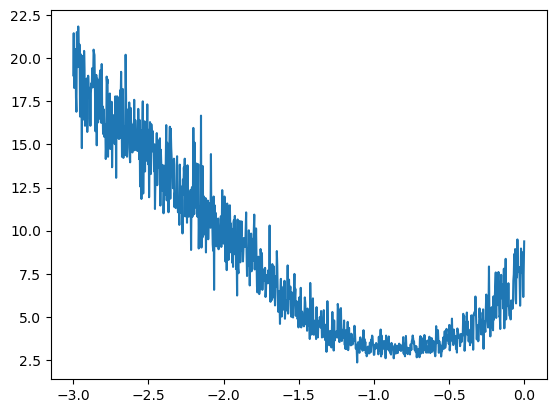

In [67]:
plt.plot(lri,lossi) # good learning rate is at somewhere between 0.0 and 0.2 ( exponent between -1.0 and -0.5)

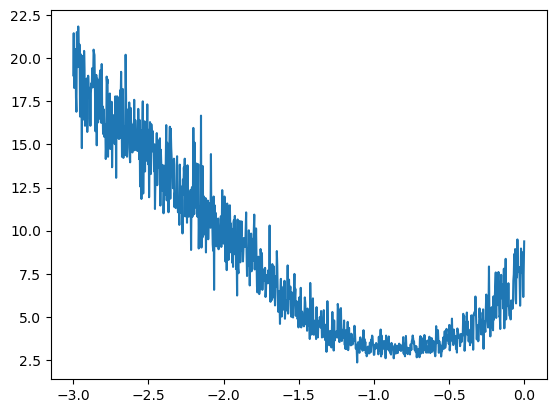

In [70]:
plt.plot(lri,lossi) # expoenent and loss

### Mini-batch training

In [73]:
torch.randint(0,X.shape[0],(32,))

tensor([ 52959, 112402, 106000,  40704, 210582, 226638, 197345,   5678,  40863,
         73639,  21716, 108822, 217478, 216134,  52632, 103535,  60607,  40490,
        194164,  96591,  73987, 215476,  78785,  26145, 219755, 150090,  99120,
        140520,    452, 186499, 205408,  92896])

In [77]:
emb = C[X] # 32,3,2
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y)
loss

tensor(2.3916, grad_fn=<NllLossBackward0>)

### Spliting the dataset

In [75]:
#training, validation ,testing

In [1]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

NameError: name 'words' is not defined

In [79]:
n1

25626

In [80]:
n2-n1

3203

In [81]:
len(words) - n2

3204

In [82]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [83]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [84]:
sum(p.nelement() for p in parameters)

11897

In [85]:
for p in parameters:
    p.requires_grad = True

In [86]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [87]:
lri = []
lossi =  []
stepi = []

Xtr[ix]:

Xtr is the training dataset.

ix contains 32 random indices, so Xtr[ix] picks 32 rows.

If Xtr has shape (N, 3) (i.e., each row has 3 integers), then Xtr[ix] has shape (32, 3).

C[Xtr[ix]]:

C is an embedding matrix (likely of shape (VocabSize, EmbeddingDim)).

Xtr[ix] contains integer indices (tokens), so C[Xtr[ix]] retrieves the embeddings for each token.

If C has shape (VocabSize, 10) (i.e., 10-dimensional embeddings), then:

Xtr[ix] (shape (32, 3)) is used as an index to look up embeddings.

The result emb = C[Xtr[ix]] has shape (32, 3, 10).

In [88]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.216202735900879


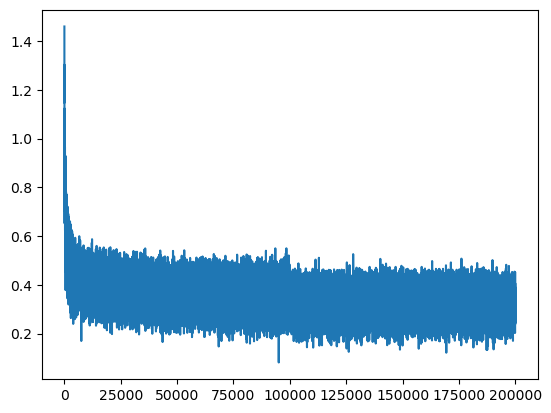

In [89]:
plt.plot(stepi,lossi)

In [90]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1608, grad_fn=<NllLossBackward0>)

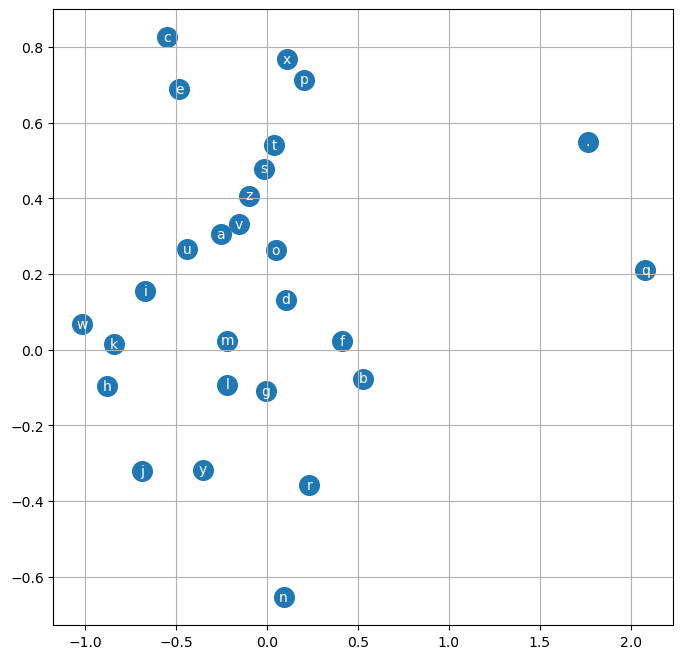

In [141]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [91]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
medhayla.
rethrestyn.
leg.
azeredielin.
shi.
jenre.
elisso.
nar.
elynn.
houraci.
shurton.
hiriel.
kin.
retlynn.
nophirius.
kavder.
yarleyelsy.
